# Current trends in AI
## An AI powered artist - @IaQuinet
### by Georges Tod

In [1]:
import requests
import random
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as display
import PIL.Image
import time
import functools
import os

from twitter import *

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0],True)



# initialization

In [2]:
#  (to be done once or to reset robot)
#np.save('answers_list',[],allow_pickle=True)
#np.save('users_answers_list',[],allow_pickle=True)

# to recover from bugs while searching images in Qwant
np.save('log',-1,allow_pickle=True)

# functions

In [3]:
def req_images(query):
    
    # this functions generates urls of images according to query
    
    r = requests.get("https://api.qwant.com/api/search/images",
        params={
            'count': 15,
            'q': query,
            't': 'images',
            'imagetype':'photo',
            'safesearch': 1,
            'uiv':20
        },
        headers={
            'User-Agent': 'fff'
        }
    )

    response = r.json().get('data').get('result').get('items')
    urls = [r.get('media') for r in response]

    #plt.figure(figsize=(30,50))
    count=1
    list_valid_urls = []
    for i in urls:

        try:
            response = requests.get(i)
            #img = Image.open(BytesIO(response.content))
            #plt.subplot(10,5,count)
            #plt.imshow(img)
            list_valid_urls.append(i)

            count+=1
        except:
            pass
    return list_valid_urls



def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def clip_0_1(image):
    # Since this is a float image, define a function to keep the pixel values between 0 and 1
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

def gram_matrix(input_tensor):
    ## Calculate style
    # The content of an image is represented by the values of the intermediate feature maps.
    # It turns out, the style of an image can be described by the means and correlations across the different feature maps. 
    # Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, 
    # and averaging that outer product over all locations. This Gram matrix can be calcualted for a particular layer as:
    # $$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$
    # This can be implemented concisely using the `tf.linalg.einsum` function:
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
    ## Extract style and content
    # Build a model that returns the style and content tensors
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}
    
def load_img(path_to_img):
    # Define a function to load an image and limit its maximum dimension to 512 pixels.
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)
        
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss


# Load a VGG19
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# Choose intermediate layers from the network to represent the style and content of the image
content_layers = ['block5_conv2']  # Content layer where will pull our feature maps
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## twitter authentication

In [4]:
h = np.load('authen.npy',allow_pickle=True) # to mask secrets...
t = Twitter(auth=OAuth(h[0], h[1], h[2], h[3]))

# Start robot online

0
I am late, I can go!
1263796322727014401 IA Quinet IaQuinet 749616853698355201 None
1261931485315072000 Greg Greg53838158 960981999711326208 1261703848550371328
1261721612010782720 Stéphane Lefèvre cagou007 2883285551 None
1261721447321554945 Stéphane Lefèvre cagou007 2883285551 1261703848550371328
I might be missing this person? I need to do more checks.
I might be missing this person? I need to do more checks.
I might be missing this person? I need to do more checks.
I might be missing this person? I need to do more checks.
749616853698355201 IaQuinet Can I produce art for myself? @IaQuinet
960981999711326208 Greg53838158 @mIAtisse Hello petit robot ! Fais moi un tableau!
2883285551 cagou007 Fais moi un tableau @mIAtisse !
2883285551 cagou007 @mIAtisse Salut l’artiste !
[1261931485315072000, 960981999711326208, 'Greg53838158']
I am late, I can go!
France Inter
Libération
Agence France-Presse
Barack Obama
https://cbsnews1.cbsistatic.com/hub/i/r/2012/06/06/a6be8bb1-a644-11e2-a3f0-029

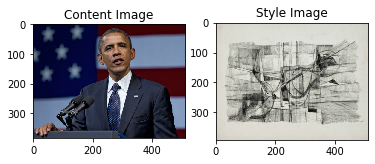

....................................................................................................Train step: 100
....................................................................................................Train step: 200
....................................................................................................Train step: 300
....................................................................................................Train step: 400
....................................................................................................Train step: 500
....................................................................................................Train step: 600
....................................................................................................Train step: 700
....................................................................................................Train step: 800
........................................................................

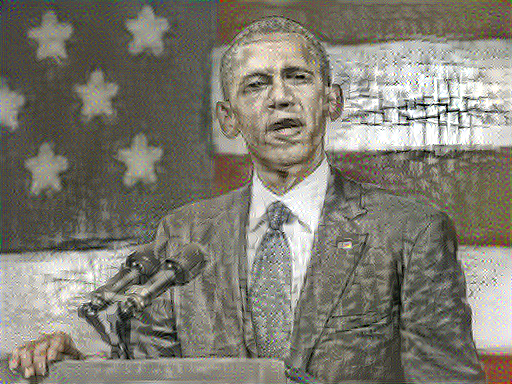

Total time: 44.5
I have written on twitter!
--------------------------------------------
[1263796322727014401, 749616853698355201, 'IaQuinet']
I am going too fast, I will wait a bit!
Jimi Hendrix
http://1.bp.blogspot.com/-HqyjMigsgKE/UKlBZVhvisI/AAAAAAAAhMI/iiO2CgtBOtk/s1600/Jimi_Hendrix-quotes.jpg
147456/146582 [==============================] - 0s 1us/step


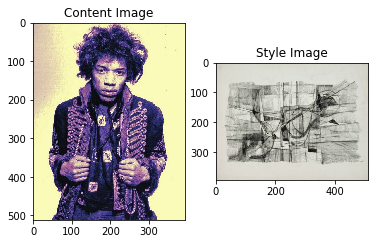

....................................................................................................Train step: 100
....................................................................................................Train step: 200
....................................................................................................Train step: 300
....................................................................................................Train step: 400
....................................................................................................Train step: 500
....................................................................................................Train step: 600
....................................................................................................Train step: 700
....................................................................................................Train step: 800
........................................................................

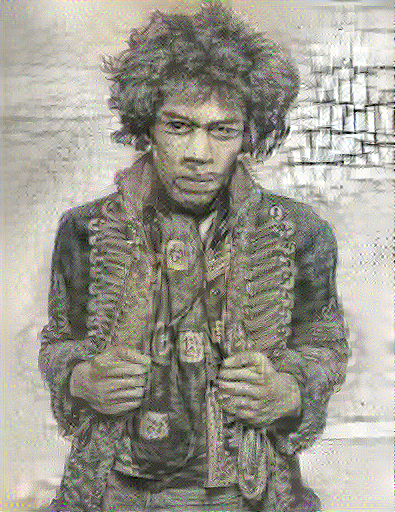

Total time: 50.6
I have written on twitter!
--------------------------------------------
[1261721612010782720, 2883285551, 'cagou007']
I am going too fast, I will wait a bit!
Aubervilliers en commun
Barack Obama
https://image.cnbcfm.com/api/v1/image/104917714-GettyImages-456540086rr.jpg?v=1532563708


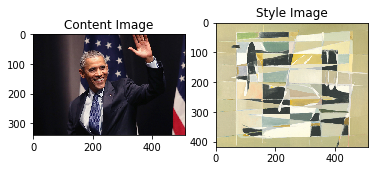

....................................................................................................Train step: 100
....................................................................................................Train step: 200
....................................................................................................Train step: 300
....................................................................................................Train step: 400
....................................................................................................Train step: 500
....................................................................................................Train step: 600
....................................................................................................Train step: 700
....................................................................................................Train step: 800
........................................................................

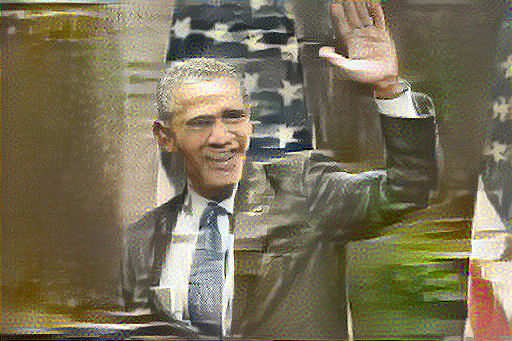

Total time: 41.8
I have written on twitter!
--------------------------------------------
Im done with this round of tweets!
################################################
1
I am late, I can go!
1263797816708734978 IA Quinet IaQuinet 749616853698355201 1263796322727014401
1263796322727014401 IA Quinet IaQuinet 749616853698355201 None
1261931485315072000 Greg Greg53838158 960981999711326208 1261703848550371328
1261721612010782720 Stéphane Lefèvre cagou007 2883285551 None
1261721447321554945 Stéphane Lefèvre cagou007 2883285551 1261703848550371328
I might be missing this person? I need to do more checks.
I already produced art for the author of this tweet!
I already produced art for the author of this tweet!
I already produced art for the author of this tweet!
I might be missing this person? I need to do more checks.
749616853698355201 IaQuinet Merci de t'intéresser à moi! Je ne suis que des lignes de codes mais je pense que tu portes un certain intérêt pour… https://t.co/m8ir4rErtp
288

In [5]:

life_is_too_short = 3 # time that I will be online in minutes




# twitter API dynamic limitations: we limit our artist to 1 API request per minute!
lag = 60

toc0 = lag
toc1 = lag



for yolo in range(life_is_too_short):
    print(yolo)
    
    # API dynamics
    rest0 = lag-toc0

    if rest0 > 0:
        print('I am going too fast, I will wait a bit!')
        time.sleep(rest0)        
    else:
        print('I am late, I can go!')
        
    tic0 = time.time()
    # checking what is new under the hood
    y = t.statuses.mentions_timeline()

    
    # scanning for mentions
    mentions_list = []

    for i in y:    
        if 'user' in i:
            print(i['id'],i['user']['name'],i['user']['screen_name'],i['user']['id'],i['in_reply_to_status_id'])
            mentions_list.append(i['id'])
        else:
            print('no')


    answers_list = np.load('answers_list.npy',allow_pickle= True)

    # scanning for unanswered
    needs_to_be = []
    for i in mentions_list:
        if i in answers_list:
            print('I already produced art for the author of this tweet!')
        else:
            print('I might be missing this person? I need to do more checks.')
            needs_to_be.append(i)

    l_users_to_answered = []
    # scanning for the user ane of potentially unanswered tweets
    for k in needs_to_be:
        for i in y:
            if i['id']== k:
                print(i['user']['id'],i['user']['screen_name'],i['text'])
                l_users_to_answered.append(i['user']['id'])

    # filtering tweet to answer
    users_answers_list = np.load('users_answers_list.npy',allow_pickle= True)
    
    tweet_user_to_answer = []
    for k in set(l_users_to_answered):
        count = 1
        for i in y:    
            if 'user' in i:
                if i['user']['id']== k and count ==1 and not i['user']['id'] in users_answers_list:
                    tweet_user_to_answer.append([i['id'],i['user']['id'],i['user']['screen_name']])
                    count += 1
    tweet_user_to_answer



    ibug = np.load('log.npy',allow_pickle=True)

    tweet_user_to_answerB = tweet_user_to_answer[ibug+1:]

    # this is going to happen per tweet
    count=0
    for j in tweet_user_to_answerB:
        print(j)
        rest = lag-toc1

        if rest > 0:
            print('I am going too fast, I will wait a bit!')
            time.sleep(rest)
            tic1 = time.time()
                
        else:
            print('I am late, I can go!')
            tic1 = time.time()

        c = t.friends.list(screen_name=j[2])


        # extracting info from account
        try:
            # try to find an image linked to interests of person, otherwise: Darth Vader!
            max_f = 1
            for i in c['users']:
                if i['followers_count'] > max_f:
                    print(i['name'])
                    max_f = i['followers_count']
                    id_max_f = i['name']



            # finding an image with some randomness
            list_images = req_images(id_max_f)
            index_image = random.randint(1,len(list_images))
            link_IM = list_images[index_image-1]
        except:
            link_IM = 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Darth_vader_hot_air_balloon_1.jpg/470px-Darth_vader_hot_air_balloon_1.jpg'
            id_max_f = 'Darth Vader'

        url_content = link_IM
        filename_content = link_IM[link_IM.rfind('/')+1:]

        print(url_content)
        response = requests.get(url_content, stream = True)

        
        # Neural style transfer needs to happen
        # this piece of code comes from a Tensorflow tutorial, it is not mine ! 

        ############### INPUTS ###############
        # loading content
        content_path = tf.keras.utils.get_file(filename_content,url_content)

        # loading a painting as style from amazing Mig Quinet
        basepath = './ref_paintings'
        dirList=[]
        for fname in os.listdir(basepath):
            path = os.path.join(basepath, fname)
            if os.path.isdir(path):
                # skip directories
                continue
            else:
                dirList.append(fname)
        nFiles = len(dirList)
        filename_style = dirList[random.randint(0,nFiles-1)]
        style_path = os.path.join('./ref_paintings/',filename_style)

        # load them        
        content_image = load_img(content_path)
        style_image = load_img(style_path)

        # plotting
        plt.subplot(1, 2, 1)
        imshow(content_image, 'Content Image')

        plt.subplot(1, 2, 2)
        imshow(style_image, 'Style Image')
        
        plt.show()



        ############### OPTIMIZER ###############

        # loss function parameters
        style_weight=1e-2
        content_weight=1e4

        # some optimization options
        epochs = 10
        steps_per_epoch = 100
        opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)


        ############### COMPUTATION ###############
        # Create the model
        style_extractor = vgg_layers(style_layers)
        style_outputs = style_extractor(style_image*255)

        # When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:
        extractor = StyleContentModel(style_layers, content_layers)
        results = extractor(tf.constant(content_image))
        style_results = results['style']

        # With this style and content extractor, you can now implement the style transfer algorithm. 
        style_targets = extractor(style_image)['style']
        content_targets = extractor(content_image)['content']

        # Define a `tf.Variable` to contain the image to optimize
        image = tf.Variable(content_image)

        # Use `tf.GradientTape` to update the image.
        @tf.function()
        def train_step(image):
            with tf.GradientTape() as tape:
                outputs = extractor(image)
                loss = style_content_loss(outputs)

            grad = tape.gradient(loss, image)
            opt.apply_gradients([(grad, image)])
            image.assign(clip_0_1(image))

        @tf.function()
        def train_step(image):
            with tf.GradientTape() as tape:
                outputs = extractor(image)
                loss = style_content_loss(outputs)

            grad = tape.gradient(loss, image)
            opt.apply_gradients([(grad, image)])
            image.assign(clip_0_1(image))

        # Compute
        import time
        start = time.time()
        step = 0
        for n in range(epochs):
            for m in range(steps_per_epoch):
                step += 1
                train_step(image)
                print(".", end='')
            #display.clear_output(wait=True)
        
            print("Train step: {}".format(step))
            
        display.display(tensor_to_image(image))
        end = time.time()
        print("Total time: {:.1f}".format(end-start))


        file_name = 'stylized-image.png'
        tensor_to_image(image).save(file_name)

        ############################################################################

        # as an output we need to produce an image, perhaps reload it from disk
        with open("stylized-image.png", "rb") as imagefile:
            imagedata = imagefile.read()




        params = {"media[]": imagedata, "status": "Merci de t'intéresser à moi! Je ne suis que des lignes de codes mais je pense que tu portes un certain intérêt pour "+id_max_f+", je me trompe? @"+j[2], "in_reply_to_status_id ": j[0] }
        try:
            t.statuses.update_with_media(**params)
            print('I have written on twitter!')
            answers_list = np.append(answers_list,j[0])
            users_answers_list = np.append(users_answers_list,j[1])
            np.save('answers_list',answers_list, allow_pickle= True)
            np.save('users_answers_list',users_answers_list, allow_pickle= True)


            # logging success in case of bug
            np.save('log',count,allow_pickle=True)

        except:
            print('I couldnt write on twitter!')


        count+=1
        
        toc1 = time.time()-tic1
        print('--------------------------------------------')
        
    toc0 = time.time()-tic0



    print('Im done with this round of tweets!')
    print('################################################')

print('I have worked, will rest now.')